In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/arifhandoyo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 94


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(39895, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,942601104A1#03,942601104A1,942601104,1,2022_03,6,NP,53MPT,-14.776987,-15.182467,...,-13.212063,-14.294167,-14.038715,-16.208555,-14.420630,9426,0,0.866393,R15C7,0.822281
1,942601104A1#05,942601104A1,942601104,1,2022_03,6,NP,53MPT,-15.166569,-14.831324,...,-14.706003,-14.648756,-13.807638,-15.991085,-15.009001,9426,0,0.866393,R15C7,0.822281
2,942601104A1#11,942601104A1,942601104,1,2022_03,6,NP,53MPT,-17.008646,-16.666145,...,-15.382391,-15.002567,-13.984061,-15.684948,-15.577260,9426,0,0.866393,R13C14,0.708233
3,942601104A1#12,942601104A1,942601104,1,2022_03,6,NP,53MPT,-16.779637,-16.071871,...,-14.780792,-15.104682,-14.952440,-16.174284,-15.360878,9426,0,0.866393,R3C7,0.665882
4,942601104A1#14,942601104A1,942601104,1,2022_03,6,NP,53MPT,-14.387767,-14.195407,...,-15.074583,-14.689997,-15.340458,-14.071941,-14.686443,9426,0,0.866393,R14C14,0.831658


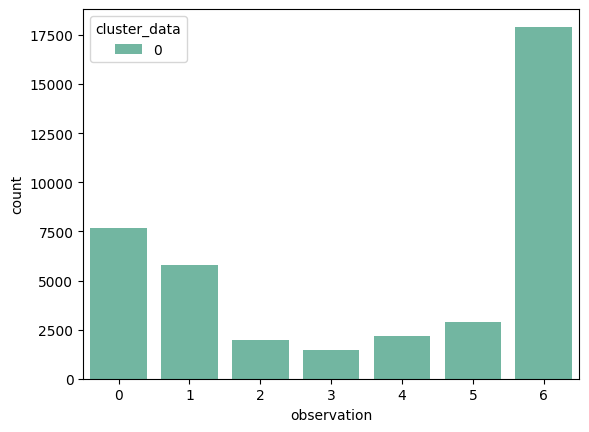

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-25 13:54:46,626] A new study created in memory with name: no-name-98dfc9d5-6818-4edf-b389-3e9f90aa9ed0


[6 4 1 2 3 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-25 13:55:48,760] Trial 0 finished with value: 0.4761347232262854 and parameters: {'max_depth': 10, 'learning_rate': 0.04725324257623295, 'reg_lambda': 4.788264693691611, 'min_child_weight': 84}. Best is trial 0 with value: 0.4761347232262854.
[I 2024-10-25 13:56:18,192] Trial 1 finished with value: 0.4601921418980613 and parameters: {'max_depth': 7, 'learning_rate': 0.06958296560556217, 'reg_lambda': 1.3911817598690943, 'min_child_weight': 65}. Best is trial 0 with value: 0.4761347232262854.
[I 2024-10-25 13:56:45,435] Trial 2 finished with value: 0.46178316760583793 and parameters: {'max_depth': 7, 'learning_rate': 0.05686872367976736, 'reg_lambda': 0.6497236569973827, 'min_child_weight': 59}. Best is trial 0 with value: 0.4761347232262854.
[I 2024-10-25 13:57:19,527] Trial 3 finished with value: 0.4687063453763323 and parameters: {'max_depth': 8, 'learning_rate': 0.04814997685986038, 'reg_lambda': 3.409867329628546, 'min_child_weight': 80}. Best is trial 0 with value: 0.47

[I 2024-10-24 09:47:04,347] Trial 10 finished with value: 0.47764201625077735 and parameters: {'max_depth': 10, 'learning_rate': 0.06683280267291698, 'reg_lambda': 0.3345003813486147, 'min_child_weight': 50}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:47:42,557] Trial 11 finished with value: 0.47596178174543663 and parameters: {'max_depth': 10, 'learning_rate': 0.07022297525675059, 'reg_lambda': 0.19603317637107387, 'min_child_weight': 50}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:48:34,215] Trial 12 finished with value: 0.4759688321520894 and parameters: {'max_depth': 10, 'learning_rate': 0.05097953242449267, 'reg_lambda': 0.21431556089069279, 'min_child_weight': 51}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:49:37,865] Trial 13 finished with value: 0.4770634485382527 and parameters: {'max_depth': 10, 'learning_rate': 0.04301190296384359, 'reg_lambda': 0.10364752945817912, 'min_child_weight': 66}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:50:51,505] Trial 14 finished with value: 0.47300301235029224 and parameters: {'max_depth': 9, 'learning_rate': 0.03647480959347015, 'reg_lambda': 1.9307613212687473, 'min_child_weight': 66}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:52:10,739] Trial 15 finished with value: 0.46855325063911396 and parameters: {'max_depth': 10, 'learning_rate': 0.03550980164147698, 'reg_lambda': 1.899221830001889, 'min_child_weight': 80}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:52:58,912] Trial 16 finished with value: 0.47460518373573374 and parameters: {'max_depth': 9, 'learning_rate': 0.06114038209296488, 'reg_lambda': 0.2526926658040529, 'min_child_weight': 66}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:54:04,329] Trial 17 finished with value: 0.4686755501882664 and parameters: {'max_depth': 10, 'learning_rate': 0.04626550589667163, 'reg_lambda': 3.6138879594076307, 'min_child_weight': 84}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:54:42,977] Trial 18 finished with value: 0.4640711485838385 and parameters: {'max_depth': 7, 'learning_rate': 0.07770780531794357, 'reg_lambda': 1.9045069568149997, 'min_child_weight': 64}. Best is trial 10 with value: 0.47764201625077735.


[I 2024-10-24 09:55:32,754] Trial 19 finished with value: 0.46932094590387674 and parameters: {'max_depth': 9, 'learning_rate': 0.057968455711484075, 'reg_lambda': 4.951499362274207, 'min_child_weight': 58}. Best is trial 10 with value: 0.47764201625077735.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.06683280267291698, 'reg_lambda': 0.3345003813486147, 'min_child_weight': 50}
Best Score: 0.47764201625077735
Start the modelling


[0]	train-mlogloss:1.86439	eval-mlogloss:1.90109


[100]	train-mlogloss:0.35069	eval-mlogloss:1.16354


[200]	train-mlogloss:0.17000	eval-mlogloss:1.09015


[300]	train-mlogloss:0.10258	eval-mlogloss:1.08015


[400]	train-mlogloss:0.07155	eval-mlogloss:1.08728


[500]	train-mlogloss:0.05441	eval-mlogloss:1.10045


[600]	train-mlogloss:0.04361	eval-mlogloss:1.11365


[700]	train-mlogloss:0.03634	eval-mlogloss:1.12655


[800]	train-mlogloss:0.03127	eval-mlogloss:1.13839


[900]	train-mlogloss:0.02743	eval-mlogloss:1.15029


[1000]	train-mlogloss:0.02455	eval-mlogloss:1.16003


[1100]	train-mlogloss:0.02226	eval-mlogloss:1.16917


[1200]	train-mlogloss:0.02045	eval-mlogloss:1.17804


[1296]	train-mlogloss:0.01901	eval-mlogloss:1.18585


[0]	train-mlogloss:1.86254	eval-mlogloss:1.89897


[100]	train-mlogloss:0.34009	eval-mlogloss:1.15414


[200]	train-mlogloss:0.17197	eval-mlogloss:1.09741


[300]	train-mlogloss:0.10636	eval-mlogloss:1.09247


[400]	train-mlogloss:0.07415	eval-mlogloss:1.10189


[500]	train-mlogloss:0.05570	eval-mlogloss:1.11475


[600]	train-mlogloss:0.04446	eval-mlogloss:1.12955


[700]	train-mlogloss:0.03698	eval-mlogloss:1.14281


[800]	train-mlogloss:0.03161	eval-mlogloss:1.15656


[900]	train-mlogloss:0.02770	eval-mlogloss:1.17031


[1000]	train-mlogloss:0.02464	eval-mlogloss:1.18206


[1100]	train-mlogloss:0.02232	eval-mlogloss:1.19211


[1200]	train-mlogloss:0.02047	eval-mlogloss:1.20134


[1291]	train-mlogloss:0.01910	eval-mlogloss:1.20916


[0]	train-mlogloss:1.86281	eval-mlogloss:1.90250


[100]	train-mlogloss:0.32764	eval-mlogloss:1.18408


[200]	train-mlogloss:0.16490	eval-mlogloss:1.12171


[300]	train-mlogloss:0.10137	eval-mlogloss:1.11607


[400]	train-mlogloss:0.07087	eval-mlogloss:1.12619


[500]	train-mlogloss:0.05347	eval-mlogloss:1.13963


[600]	train-mlogloss:0.04293	eval-mlogloss:1.15521


[700]	train-mlogloss:0.03587	eval-mlogloss:1.16938


[800]	train-mlogloss:0.03108	eval-mlogloss:1.18138


[900]	train-mlogloss:0.02726	eval-mlogloss:1.19362


[1000]	train-mlogloss:0.02430	eval-mlogloss:1.20561


[1100]	train-mlogloss:0.02208	eval-mlogloss:1.21595


[1200]	train-mlogloss:0.02023	eval-mlogloss:1.22523


[1274]	train-mlogloss:0.01909	eval-mlogloss:1.23146


[0]	train-mlogloss:1.86381	eval-mlogloss:1.89820


[50]	train-mlogloss:0.60765	eval-mlogloss:1.25766


[100]	train-mlogloss:0.38368	eval-mlogloss:1.14538


[150]	train-mlogloss:0.27239	eval-mlogloss:1.09169


[200]	train-mlogloss:0.20221	eval-mlogloss:1.06125


[250]	train-mlogloss:0.15635	eval-mlogloss:1.04580


[300]	train-mlogloss:0.12528	eval-mlogloss:1.03872


[350]	train-mlogloss:0.10320	eval-mlogloss:1.03661


[400]	train-mlogloss:0.08696	eval-mlogloss:1.03788


[412]	train-mlogloss:0.08350	eval-mlogloss:1.03859



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      5389
           1       0.58      0.54      0.56      4043
           2       0.57      0.28      0.38      1365
           3       0.54      0.32      0.40      1032
           4       0.56      0.38      0.45      1540
           5       0.54      0.32      0.41      2013
           6       0.68      0.81      0.74     12545

    accuracy                           0.64     27927
   macro avg       0.58      0.47      0.51     27927
weighted avg       0.62      0.64      0.62     27927



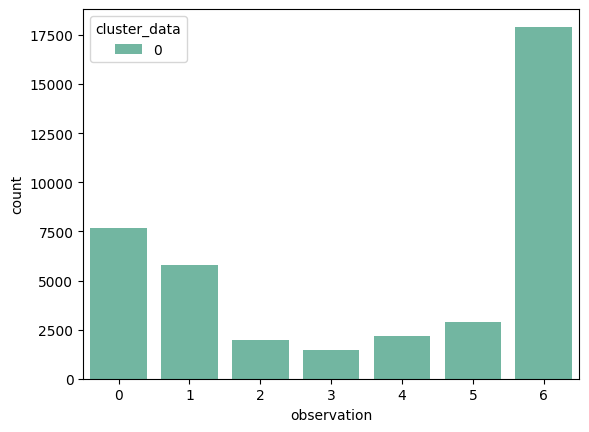

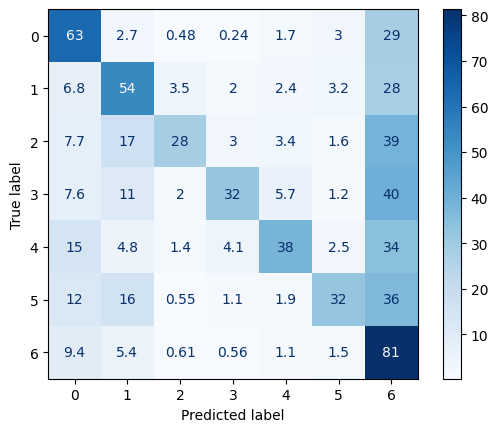

{'average_accuracy': 0.6239137787646186, 'average_f1_macro': np.float64(0.4748605200576912), 'average_f1_micro': np.float64(0.6239137787646186), 'average_auc': np.float64(0.8429621573520917), 'average_acc_kelas_generatif': 0.3114389900104186, 'average_acc_fase_padi': 0.37982456140350873}
{'val_accuracy': 0.6359437103877967, 'val_f1_macro': np.float64(0.5095847532831218), 'val_f1_micro': np.float64(0.6359437103877967), 'val_auc': np.float64(0.8667603060742011), 'val_acc_kelas_generatif': 0.3246124031007752, 'val_acc_fase_padi': 0.4370927318295739, 'val_relative_acc': np.float64(91.32412104250481)}


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [ ]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)